**Logistic Regression**

STEP 1: Upload your training file (train (1).csv)
Click the 'Choose Files' button and select your training data


Saving train (1).csv to train (1) (1).csv

STEP 2: Upload your test file (test (1).csv)
Click the 'Choose Files' button again and select your test data


Saving test (1).csv to test (1).csv


<ipython-input-3-865e8895fa48>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataTrain['Arrival Delay in Minutes'].fillna(dataTrain['Arrival Delay in Minutes'].median(), inplace=True)
<ipython-input-3-865e8895fa48>:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 


MODEL EVALUATION METRICS:
Logistic Regression Accuracy: 0.8425

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87     14573
           1       0.86      0.77      0.81     11403

    accuracy                           0.84     25976
   macro avg       0.85      0.83      0.84     25976
weighted avg       0.84      0.84      0.84     25976


Confusion Matrix:
[[13124  1449]
 [ 2643  8760]]


<ipython-input-3-865e8895fa48>:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=coefficients, palette='viridis')


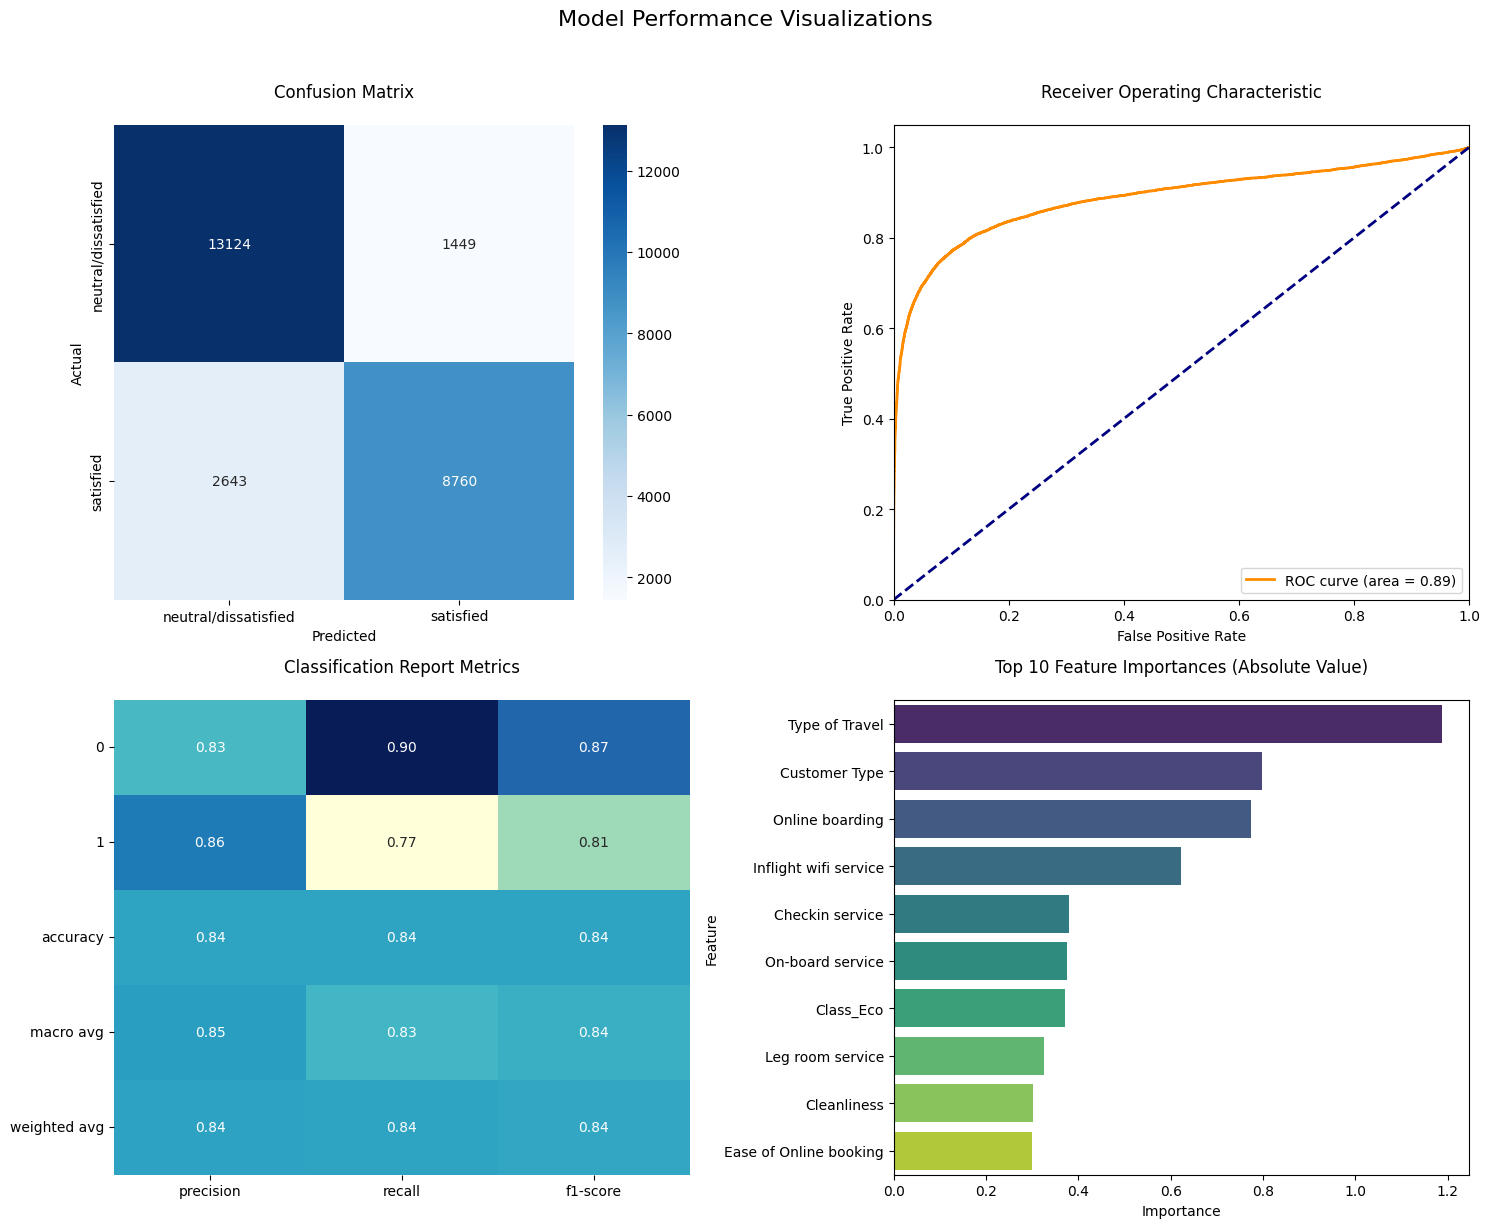

In [3]:
#Logistic Regression Model for an imbalanced dataset using SMOTE

from google.colab import files
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

print("STEP 1: Upload your training file (train (1).csv)")
print("Click the 'Choose Files' button and select your training data")
train_uploaded = files.upload()
print("\nSTEP 2: Upload your test file (test (1).csv)")
print("Click the 'Choose Files' button again and select your test data")
test_uploaded = files.upload()

train_filename = list(train_uploaded.keys())[0]
test_filename = list(test_uploaded.keys())[0]

dataTrain = pd.read_csv(train_filename)
dataTest = pd.read_csv(test_filename)

dataTrain.drop_duplicates(inplace=True)

dataTrain['Arrival Delay in Minutes'].fillna(dataTrain['Arrival Delay in Minutes'].median(), inplace=True)
dataTest['Arrival Delay in Minutes'].fillna(dataTest['Arrival Delay in Minutes'].median(), inplace=True)

def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
    return df

numerical_cols = ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
dataTrain = remove_outliers(dataTrain, numerical_cols)

dataTrain = pd.get_dummies(dataTrain, columns=['Class'], drop_first=True, dtype=int)
dataTest = pd.get_dummies(dataTest, columns=['Class'], drop_first=True, dtype=int)

for col in ['Gender','Customer Type','Type of Travel']:
    le = LabelEncoder()
    dataTrain[col] = le.fit_transform(dataTrain[col])
    dataTest[col] = le.transform(dataTest[col])

dataTrain['satisfaction'] = dataTrain['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})
dataTest['satisfaction'] = dataTest['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})

dataTrain, dataTest = dataTrain.align(dataTest, join='inner', axis=1)
dataTest['satisfaction'] = dataTest['satisfaction']

X_train = dataTrain.drop('satisfaction', axis=1)
y_train = dataTrain['satisfaction']
X_test = dataTest.drop('satisfaction', axis=1)
y_test = dataTest['satisfaction']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve

print("\nMODEL EVALUATION METRICS:")
print("="*50)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(15, 12))
plt.suptitle("Model Performance Visualizations", y=1.02, fontsize=16)

# 1. Confusion Matrix
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['neutral/dissatisfied', 'satisfied'],
            yticklabels=['neutral/dissatisfied', 'satisfied'])
plt.title('Confusion Matrix', pad=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 2. ROC Curve
plt.subplot(2, 2, 2)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic', pad=20)
plt.legend(loc="lower right")

# 3. Classification Report Heatmap
plt.subplot(2, 2, 3)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).iloc[:-1, :].T
sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='.2f', cbar=False)
plt.title('Classification Report Metrics', pad=20)
plt.tight_layout()

# 4. Feature Importance
plt.subplot(2, 2, 4)
if hasattr(model, 'coef_'):
    coefficients = pd.DataFrame({
        'Feature': dataTrain.drop('satisfaction', axis=1).columns,
        'Importance': np.abs(model.coef_[0])
    })
    coefficients = coefficients.sort_values(by='Importance', ascending=False).head(10)
    sns.barplot(x='Importance', y='Feature', data=coefficients, palette='viridis')
    plt.title('Top 10 Feature Importances (Absolute Value)', pad=20)
    plt.tight_layout()

plt.show()

STEP 1: Upload your training file (train (1).csv)
Click the 'Choose Files' button and select your training data


Saving train (1).csv to train (1).csv

STEP 2: Upload your test file (test (1).csv)
Click the 'Choose Files' button again and select your test data


Saving test (1).csv to test (1).csv


<ipython-input-1-532435da3c63>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataTrain['Arrival Delay in Minutes'].fillna(dataTrain['Arrival Delay in Minutes'].median(), inplace=True)
<ipython-input-1-532435da3c63>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 


Class distribution in training data (should be balanced):
satisfaction
0    41306
1    34066
Name: count, dtype: int64

MODEL EVALUATION METRICS:
Logistic Regression Accuracy: 0.8461

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87     14573
           1       0.88      0.76      0.81     11403

    accuracy                           0.85     25976
   macro avg       0.85      0.84      0.84     25976
weighted avg       0.85      0.85      0.84     25976


Confusion Matrix:
[[13347  1226]
 [ 2773  8630]]


<ipython-input-1-532435da3c63>:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=coefficients, palette='viridis')


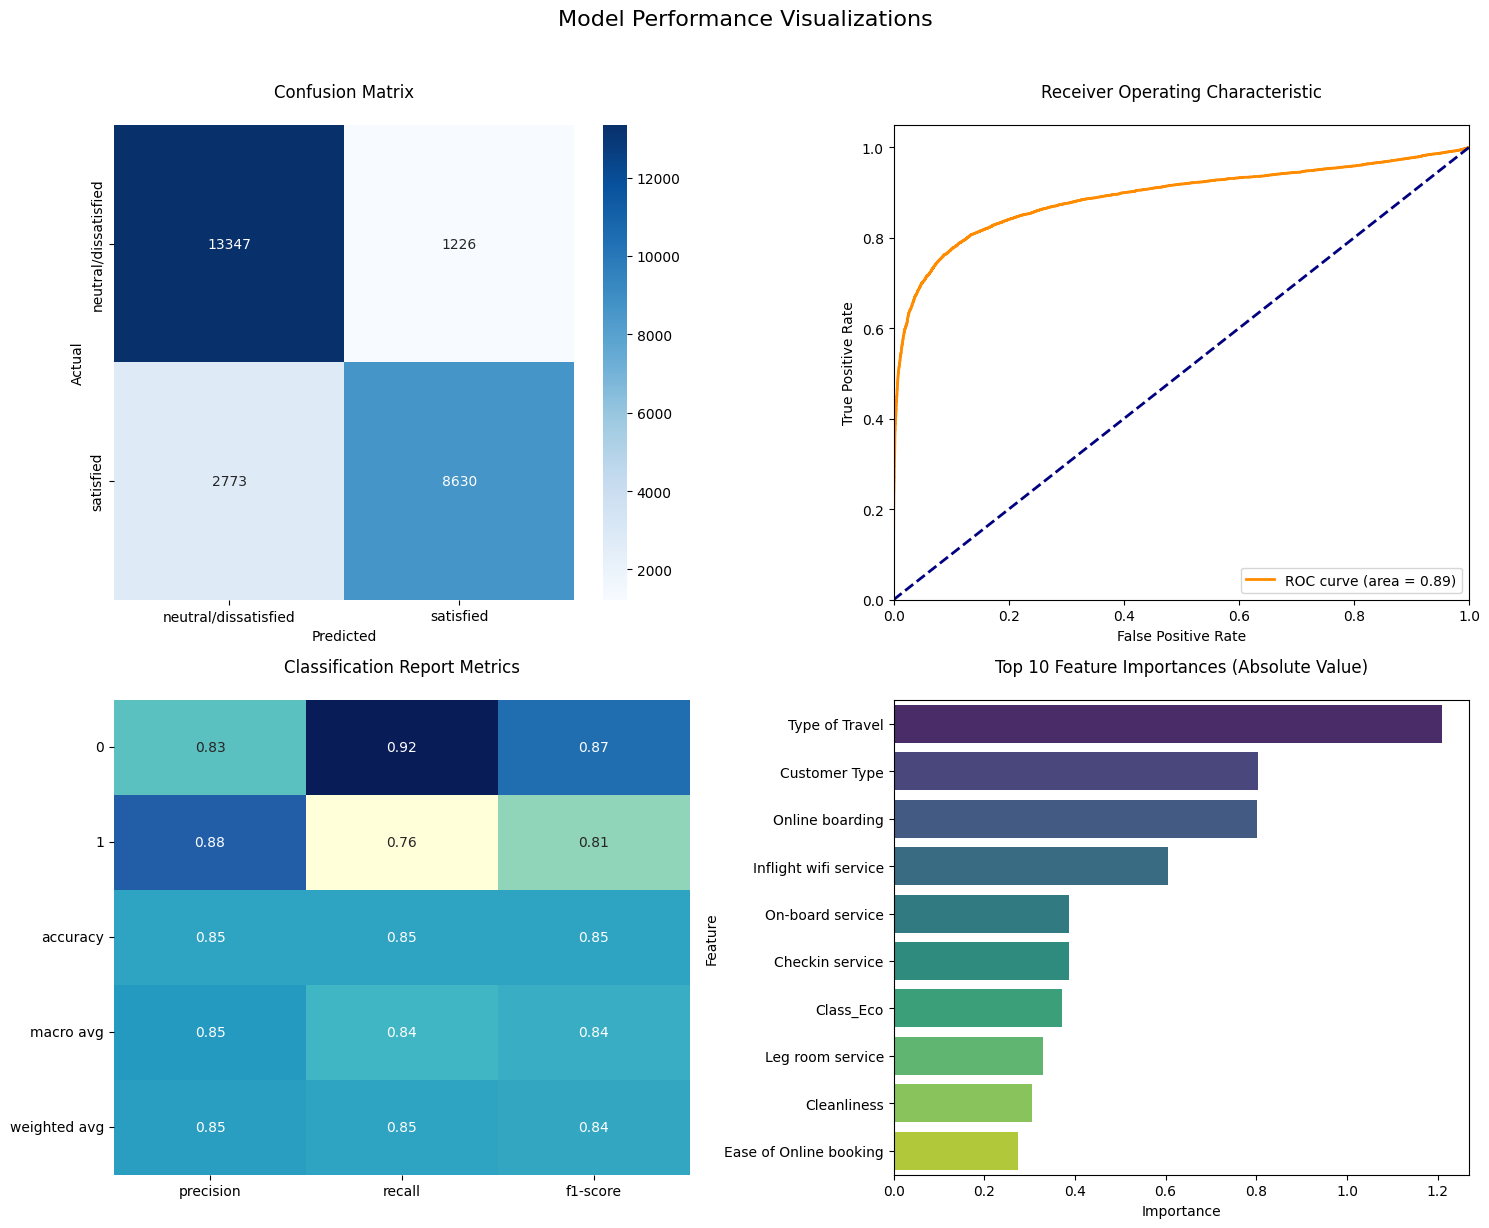

In [1]:
# Logistic Regression Model for a Balanced Dataset

from google.colab import files
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

print("STEP 1: Upload your training file (train (1).csv)")
print("Click the 'Choose Files' button and select your training data")
train_uploaded = files.upload()
print("\nSTEP 2: Upload your test file (test (1).csv)")
print("Click the 'Choose Files' button again and select your test data")
test_uploaded = files.upload()

train_filename = list(train_uploaded.keys())[0]
test_filename = list(test_uploaded.keys())[0]

dataTrain = pd.read_csv(train_filename)
dataTest = pd.read_csv(test_filename)

dataTrain.drop_duplicates(inplace=True)

dataTrain['Arrival Delay in Minutes'].fillna(dataTrain['Arrival Delay in Minutes'].median(), inplace=True)
dataTest['Arrival Delay in Minutes'].fillna(dataTest['Arrival Delay in Minutes'].median(), inplace=True)

def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
    return df

numerical_cols = ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
dataTrain = remove_outliers(dataTrain, numerical_cols)

dataTrain = pd.get_dummies(dataTrain, columns=['Class'], drop_first=True, dtype=int)
dataTest = pd.get_dummies(dataTest, columns=['Class'], drop_first=True, dtype=int)

for col in ['Gender','Customer Type','Type of Travel']:
    le = LabelEncoder()
    dataTrain[col] = le.fit_transform(dataTrain[col])
    dataTest[col] = le.transform(dataTest[col])

dataTrain['satisfaction'] = dataTrain['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})
dataTest['satisfaction'] = dataTest['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})

dataTrain, dataTest = dataTrain.align(dataTest, join='inner', axis=1)
dataTest['satisfaction'] = dataTest['satisfaction']

X_train = dataTrain.drop('satisfaction', axis=1)
y_train = dataTrain['satisfaction']
X_test = dataTest.drop('satisfaction', axis=1)
y_test = dataTest['satisfaction']

# Confirm class balance
print("\nClass distribution in training data (should be balanced):")
print(y_train.value_counts())

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nMODEL EVALUATION METRICS:")
print("="*50)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(15, 12))
plt.suptitle("Model Performance Visualizations", y=1.02, fontsize=16)

# 1. Confusion Matrix
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['neutral/dissatisfied', 'satisfied'],
            yticklabels=['neutral/dissatisfied', 'satisfied'])
plt.title('Confusion Matrix', pad=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 2. ROC Curve
plt.subplot(2, 2, 2)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic', pad=20)
plt.legend(loc="lower right")

# 3. Classification Report Heatmap
plt.subplot(2, 2, 3)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).iloc[:-1, :].T
sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='.2f', cbar=False)
plt.title('Classification Report Metrics', pad=20)
plt.tight_layout()

# 4. Feature Importance
plt.subplot(2, 2, 4)
if hasattr(model, 'coef_'):
    coefficients = pd.DataFrame({
        'Feature': dataTrain.drop('satisfaction', axis=1).columns,
        'Importance': np.abs(model.coef_[0])
    })
    coefficients = coefficients.sort_values(by='Importance', ascending=False).head(10)
    sns.barplot(x='Importance', y='Feature', data=coefficients, palette='viridis')
    plt.title('Top 10 Feature Importances (Absolute Value)', pad=20)
    plt.tight_layout()

plt.show()


**Naive Bayes (balanced)**

STEP 1: Upload your training file (train.csv)
Click the 'Choose Files' button and select your training data


Saving train (1).csv to train (1) (2).csv

STEP 2: Upload your test file (test.csv)
Click the 'Choose Files' button again and select your test data


Saving test (1).csv to test (1) (1).csv


<ipython-input-4-83a27742eaab>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataTrain['Arrival Delay in Minutes'].fillna(dataTrain['Arrival Delay in Minutes'].median(), inplace=True)
<ipython-input-4-83a27742eaab>:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 


MODEL EVALUATION METRICS:
Naive Bayes Accuracy: 0.8089

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84     14573
           1       0.86      0.68      0.76     11403

    accuracy                           0.81     25976
   macro avg       0.82      0.79      0.80     25976
weighted avg       0.82      0.81      0.80     25976


Confusion Matrix:
[[13303  1270]
 [ 3693  7710]]


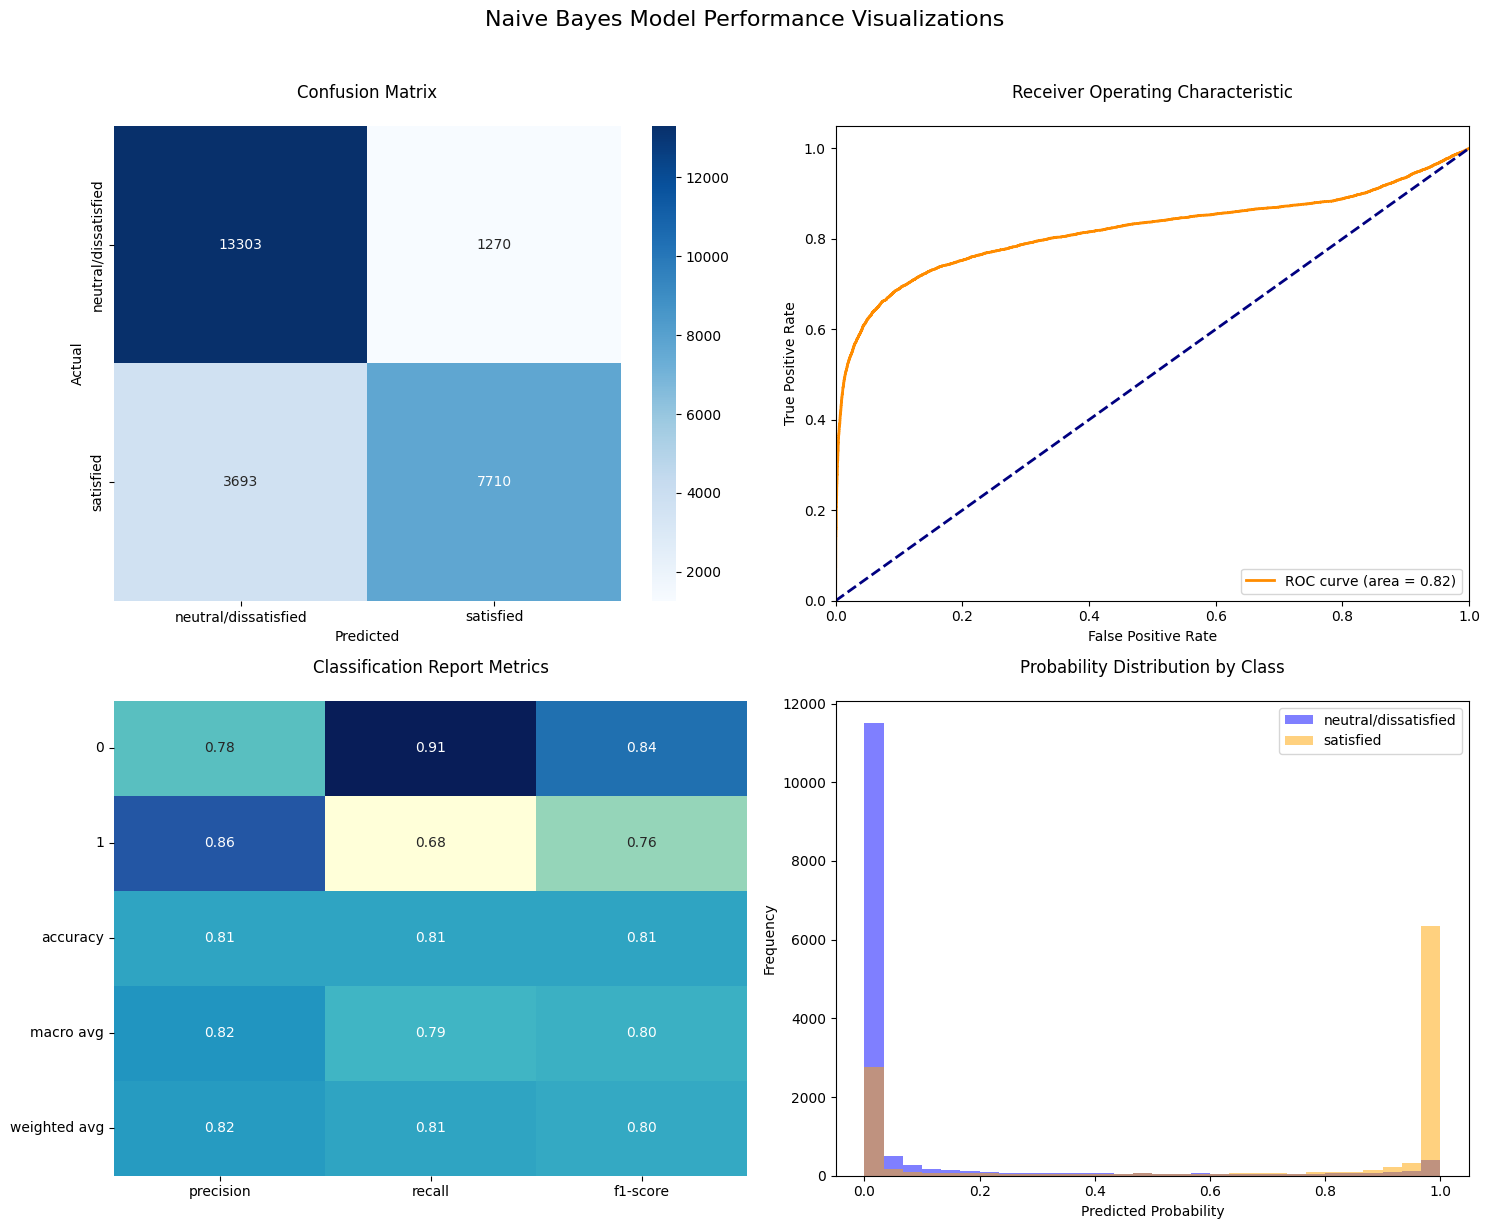

In [4]:
# Naive Bayes Model for an imbalanced dataset

from google.colab import files
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

print("STEP 1: Upload your training file (train.csv)")
print("Click the 'Choose Files' button and select your training data")
train_uploaded = files.upload()
print("\nSTEP 2: Upload your test file (test.csv)")
print("Click the 'Choose Files' button again and select your test data")
test_uploaded = files.upload()

train_filename = list(train_uploaded.keys())[0]
test_filename = list(test_uploaded.keys())[0]

dataTrain = pd.read_csv(train_filename)
dataTest = pd.read_csv(test_filename)

dataTrain.drop_duplicates(inplace=True)

dataTrain['Arrival Delay in Minutes'].fillna(dataTrain['Arrival Delay in Minutes'].median(), inplace=True)
dataTest['Arrival Delay in Minutes'].fillna(dataTest['Arrival Delay in Minutes'].median(), inplace=True)

def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
    return df

numerical_cols = ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
dataTrain = remove_outliers(dataTrain, numerical_cols)

dataTrain = pd.get_dummies(dataTrain, columns=['Class'], drop_first=True, dtype=int)
dataTest = pd.get_dummies(dataTest, columns=['Class'], drop_first=True, dtype=int)

for col in ['Gender','Customer Type','Type of Travel']:
    le = LabelEncoder()
    dataTrain[col] = le.fit_transform(dataTrain[col])
    dataTest[col] = le.transform(dataTest[col])

dataTrain['satisfaction'] = dataTrain['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})
dataTest['satisfaction'] = dataTest['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})

dataTrain, dataTest = dataTrain.align(dataTest, join='inner', axis=1)
dataTest['satisfaction'] = dataTest['satisfaction']

X_train = dataTrain.drop('satisfaction', axis=1)
y_train = dataTrain['satisfaction']
X_test = dataTest.drop('satisfaction', axis=1)
y_test = dataTest['satisfaction']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)


model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve


print("\nMODEL EVALUATION METRICS:")
print("="*50)
print(f"Naive Bayes Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


plt.figure(figsize=(15, 12))
plt.suptitle("Naive Bayes Model Performance Visualizations", y=1.02, fontsize=16)

# 1. Confusion Matrix
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['neutral/dissatisfied', 'satisfied'],
            yticklabels=['neutral/dissatisfied', 'satisfied'])
plt.title('Confusion Matrix', pad=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 2. ROC Curve
plt.subplot(2, 2, 2)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic', pad=20)
plt.legend(loc="lower right")

# 3. Classification Report Heatmap
plt.subplot(2, 2, 3)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).iloc[:-1, :].T
sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='.2f', cbar=False)
plt.title('Classification Report Metrics', pad=20)

# 4. Probability Distribution
plt.subplot(2, 2, 4)
plt.hist(y_pred_proba[y_test==0], bins=30, alpha=0.5, color='blue', label='neutral/dissatisfied')
plt.hist(y_pred_proba[y_test==1], bins=30, alpha=0.5, color='orange', label='satisfied')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution by Class', pad=20)
plt.legend()
plt.tight_layout()

plt.show()

STEP 1: Upload your training file (train.csv)
Click the 'Choose Files' button and select your training data


Saving train (1).csv to train (1) (1).csv

STEP 2: Upload your test file (test.csv)
Click the 'Choose Files' button again and select your test data


Saving test (1).csv to test (1) (1).csv


<ipython-input-2-70faa629281d>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataTrain['Arrival Delay in Minutes'].fillna(dataTrain['Arrival Delay in Minutes'].median(), inplace=True)
<ipython-input-2-70faa629281d>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 


Class distribution in training data (should be balanced):
satisfaction
0    41306
1    34066
Name: count, dtype: int64

MODEL EVALUATION METRICS:
Naive Bayes Accuracy: 0.8115

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.92      0.85     14573
           1       0.86      0.68      0.76     11403

    accuracy                           0.81     25976
   macro avg       0.82      0.80      0.80     25976
weighted avg       0.82      0.81      0.81     25976


Confusion Matrix:
[[13363  1210]
 [ 3687  7716]]


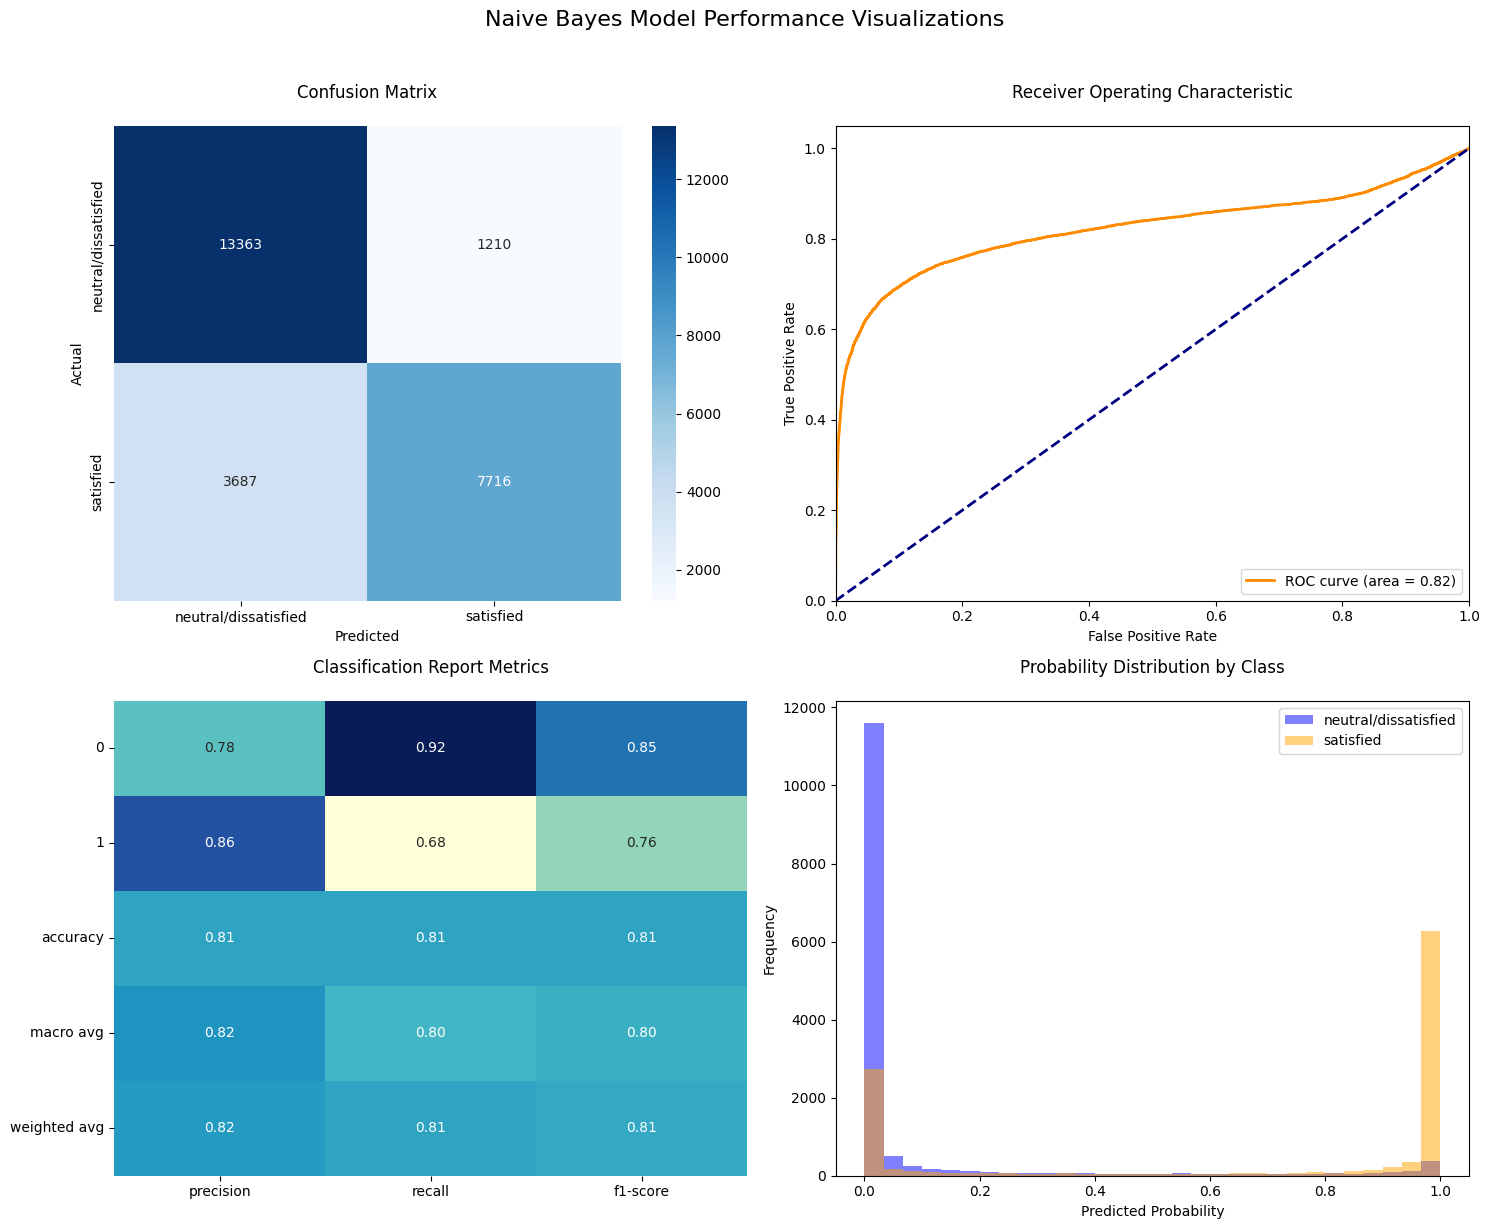

In [2]:
# Naive Bayes Model for a Balanced Dataset

from google.colab import files
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

print("STEP 1: Upload your training file (train.csv)")
print("Click the 'Choose Files' button and select your training data")
train_uploaded = files.upload()
print("\nSTEP 2: Upload your test file (test.csv)")
print("Click the 'Choose Files' button again and select your test data")
test_uploaded = files.upload()

train_filename = list(train_uploaded.keys())[0]
test_filename = list(test_uploaded.keys())[0]

dataTrain = pd.read_csv(train_filename)
dataTest = pd.read_csv(test_filename)

dataTrain.drop_duplicates(inplace=True)

dataTrain['Arrival Delay in Minutes'].fillna(dataTrain['Arrival Delay in Minutes'].median(), inplace=True)
dataTest['Arrival Delay in Minutes'].fillna(dataTest['Arrival Delay in Minutes'].median(), inplace=True)

def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
    return df

numerical_cols = ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
dataTrain = remove_outliers(dataTrain, numerical_cols)

dataTrain = pd.get_dummies(dataTrain, columns=['Class'], drop_first=True, dtype=int)
dataTest = pd.get_dummies(dataTest, columns=['Class'], drop_first=True, dtype=int)

for col in ['Gender','Customer Type','Type of Travel']:
    le = LabelEncoder()
    dataTrain[col] = le.fit_transform(dataTrain[col])
    dataTest[col] = le.transform(dataTest[col])

dataTrain['satisfaction'] = dataTrain['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})
dataTest['satisfaction'] = dataTest['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})

dataTrain, dataTest = dataTrain.align(dataTest, join='inner', axis=1)
dataTest['satisfaction'] = dataTest['satisfaction']

X_train = dataTrain.drop('satisfaction', axis=1)
y_train = dataTrain['satisfaction']
X_test = dataTest.drop('satisfaction', axis=1)
y_test = dataTest['satisfaction']

# Check class balance
print("\nClass distribution in training data (should be balanced):")
print(y_train.value_counts())

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Naive Bayes
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve

# Evaluation
print("\nMODEL EVALUATION METRICS:")
print("="*50)
print(f"Naive Bayes Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Visualizations
plt.figure(figsize=(15, 12))
plt.suptitle("Naive Bayes Model Performance Visualizations", y=1.02, fontsize=16)

# 1. Confusion Matrix
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['neutral/dissatisfied', 'satisfied'],
            yticklabels=['neutral/dissatisfied', 'satisfied'])
plt.title('Confusion Matrix', pad=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 2. ROC Curve
plt.subplot(2, 2, 2)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic', pad=20)
plt.legend(loc="lower right")

# 3. Classification Report Heatmap
plt.subplot(2, 2, 3)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).iloc[:-1, :].T
sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='.2f', cbar=False)
plt.title('Classification Report Metrics', pad=20)

# 4. Probability Distribution
plt.subplot(2, 2, 4)
plt.hist(y_pred_proba[y_test==0], bins=30, alpha=0.5, color='blue', label='neutral/dissatisfied')
plt.hist(y_pred_proba[y_test==1], bins=30, alpha=0.5, color='orange', label='satisfied')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution by Class', pad=20)
plt.legend()
plt.tight_layout()

plt.show()


**Logistic Regression XG Boost Classifier**

Installing XGBoost...
Installation complete!

STEP 1: Upload your training file (train.csv)
Click the 'Choose Files' button and select your training data


Saving train (1).csv to train (1) (4).csv

STEP 2: Upload your test file (test.csv)
Click the 'Choose Files' button again and select your test data


Saving test (1).csv to test (1) (3).csv

DATA PREPROCESSING:
Removed duplicates. Training shape: (103904, 23)
Applied label encoding to categorical features


<ipython-input-6-65d130d44123>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Arrival Delay in Minutes'].fillna(train_df['Arrival Delay in Minutes'].median(), inplace=True)
<ipython-input-6-65d130d44123>:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

Applied one-hot encoding to 'Class' feature
Mapped target variable to binary values
Applied standard scaling to features

MODEL TRAINING:


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:33:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost model trained successfully

MODEL EVALUATION:
Accuracy: 0.9609

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     14573
           1       0.97      0.94      0.95     11403

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976


Confusion Matrix:
[[14246   327]
 [  688 10715]]


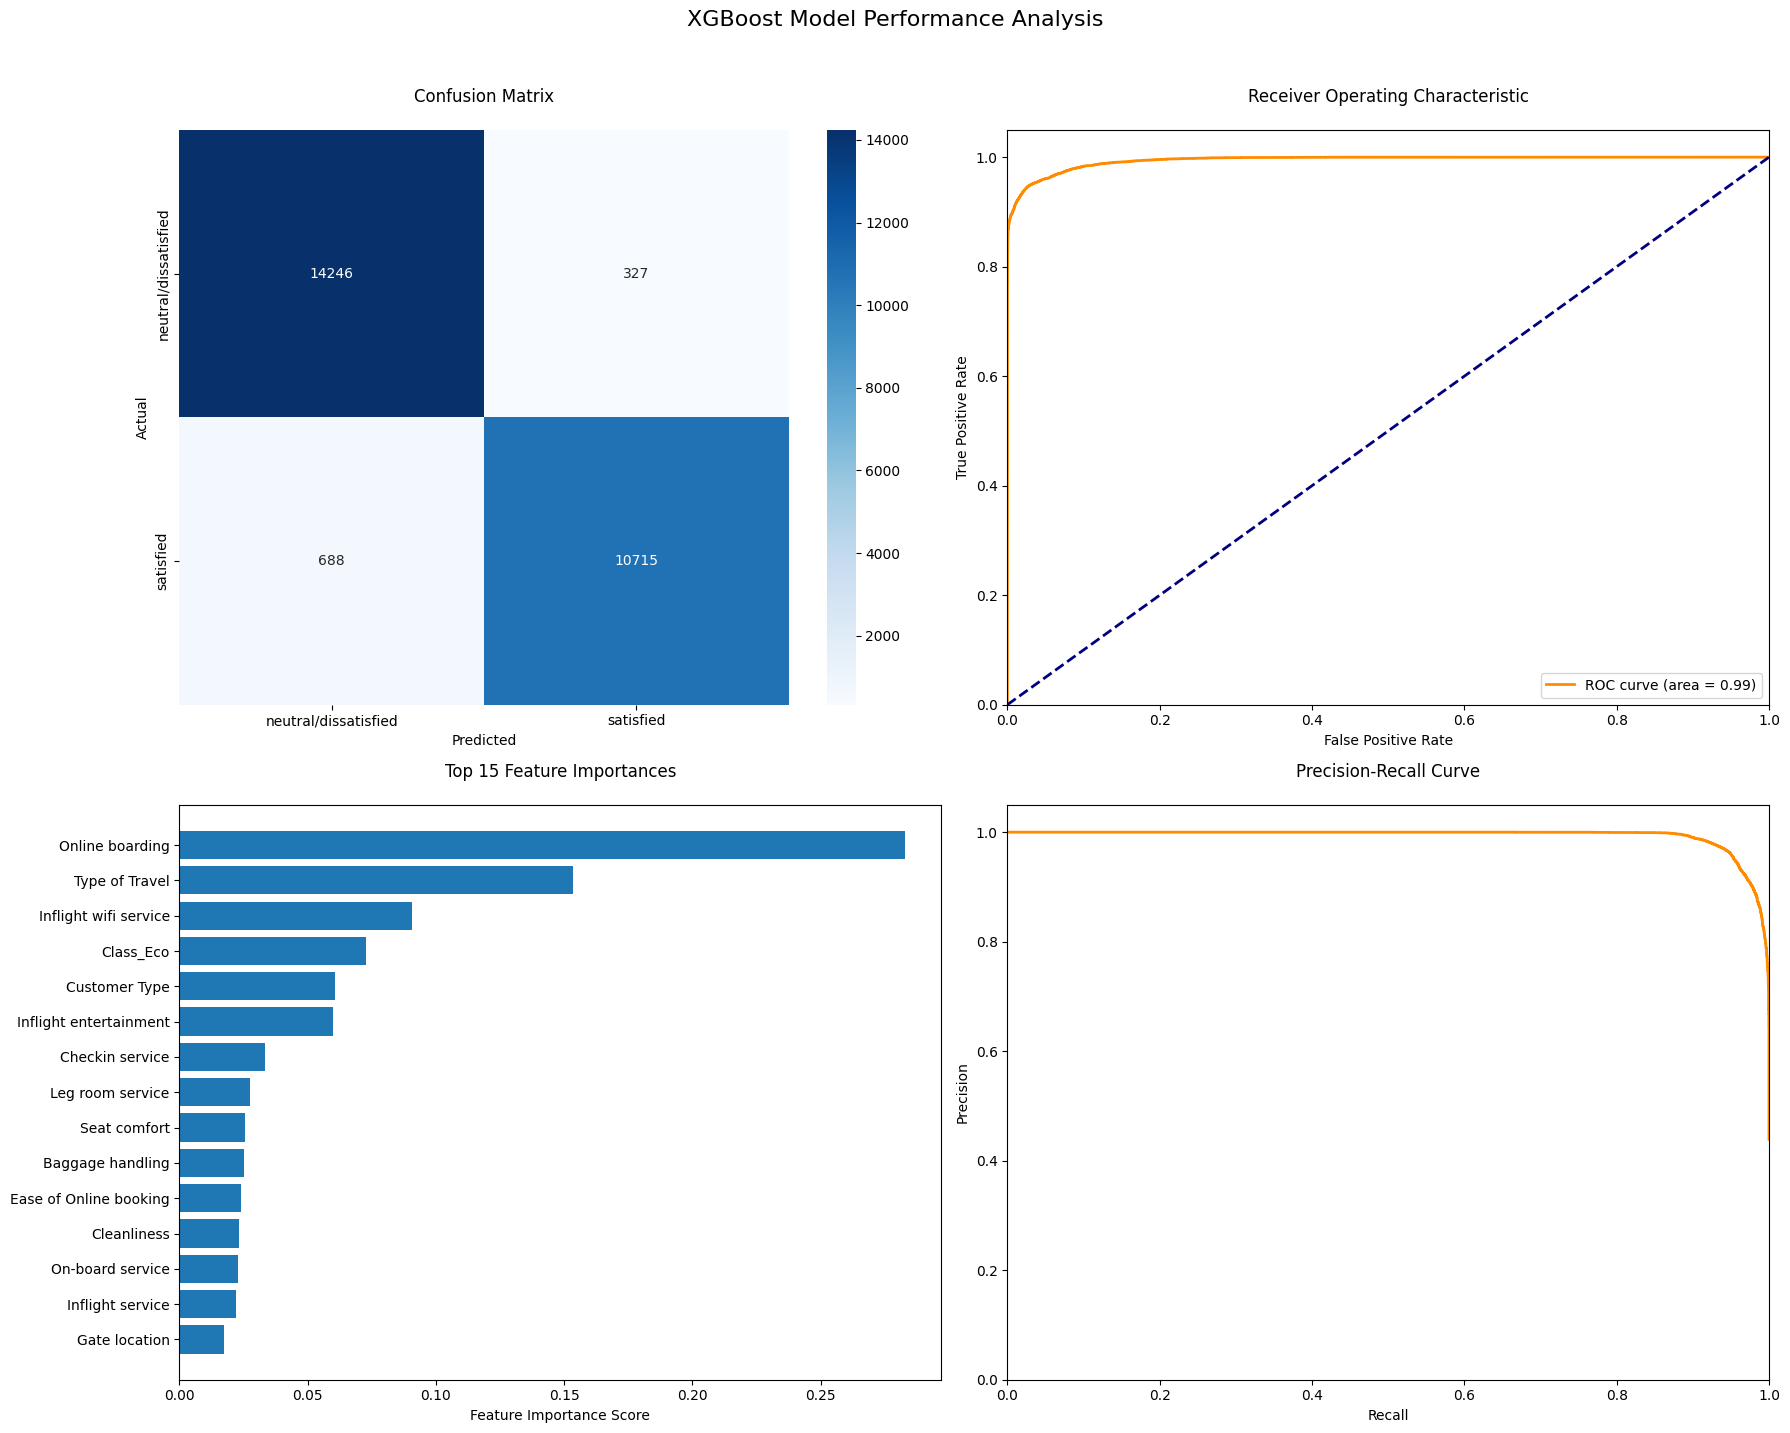

In [6]:


from google.colab import files
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

!pip install xgboost -q
print("STEP 1: Upload your training file (train.csv)")
print("Click the 'Choose Files' button and select your training data")
train_uploaded = files.upload()
print("\nSTEP 2: Upload your test file (test.csv)")
print("Click the 'Choose Files' button again and select your test data")
test_uploaded = files.upload()

train_filename = list(train_uploaded.keys())[0]
test_filename = list(test_uploaded.keys())[0]

train_df = pd.read_csv(train_filename)
test_df = pd.read_csv(test_filename)

print("\nDATA PREPROCESSING:")
print("="*50)

cols_to_drop = ['Unnamed: 0', 'id']
train_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
test_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

train_df['Arrival Delay in Minutes'].fillna(train_df['Arrival Delay in Minutes'].median(), inplace=True)
test_df['Arrival Delay in Minutes'].fillna(test_df['Arrival Delay in Minutes'].median(), inplace=True)

train_df.drop_duplicates(inplace=True)
print(f"Removed duplicates. Training shape: {train_df.shape}")

label_cols = ['Gender', 'Customer Type', 'Type of Travel']
for col in label_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
print("Applied label encoding to categorical features")

train_df = pd.get_dummies(train_df, columns=['Class'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Class'], drop_first=True)
print("Applied one-hot encoding to 'Class' feature")

train_df['satisfaction'] = train_df['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})
test_df['satisfaction'] = test_df['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})
print("Mapped target variable to binary values")

X_train = train_df.drop(columns=['satisfaction'])
y_train = train_df['satisfaction']
X_test = test_df.drop(columns=['satisfaction'])
y_test = test_df['satisfaction']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("Applied standard scaling to features")

# XGBoost model
print("\nMODEL TRAINING:")
print("="*50)
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)
print("XGBoost model trained successfully")

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("\nMODEL EVALUATION:")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(18, 14))
plt.suptitle("XGBoost Model Performance Analysis", y=1.02, fontsize=16)

# 1. Confusion Matrix
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['neutral/dissatisfied', 'satisfied'],
            yticklabels=['neutral/dissatisfied', 'satisfied'])
plt.title('Confusion Matrix', pad=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 2. ROC Curve
plt.subplot(2, 2, 2)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic', pad=20)
plt.legend(loc="lower right")

# 3. Feature Importance
plt.subplot(2, 2, 3)
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-15:]  # Top 15 features
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color='#1f77b4')
plt.yticks(range(len(sorted_idx)), np.array(train_df.drop(columns=['satisfaction']).columns)[sorted_idx])
plt.xlabel('Feature Importance Score')
plt.title('Top 15 Feature Importances', pad=20)

# 4. Precision-Recall Curve
plt.subplot(2, 2, 4)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', pad=20)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.show()


**Naive Bayes Forest Classifier**

Saving train (1).csv to train (1) (5).csv


<ipython-input-7-a39fc2000be6>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Arrival Delay in Minutes'].fillna(train_df['Arrival Delay in Minutes'].median(), inplace=True)
<ipython-input-7-a39fc2000be6>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

 Accuracy: 0.9593470896211888

 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96     14573
           1       0.96      0.94      0.95     11403

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976



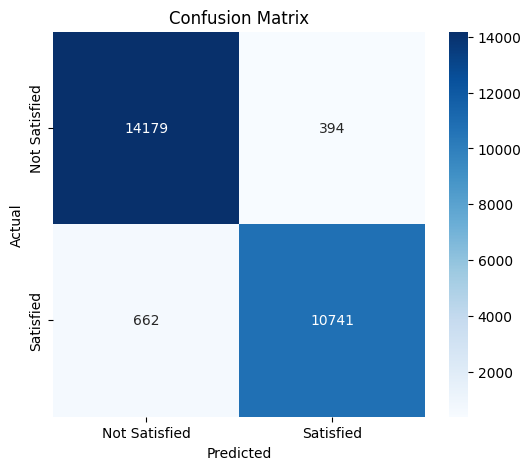

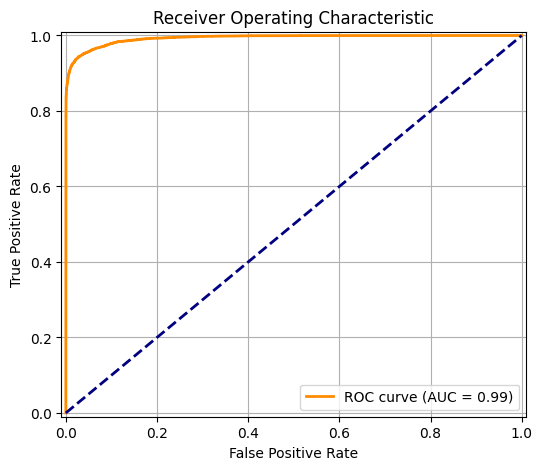

<ipython-input-7-a39fc2000be6>:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(features)[indices], palette='viridis')


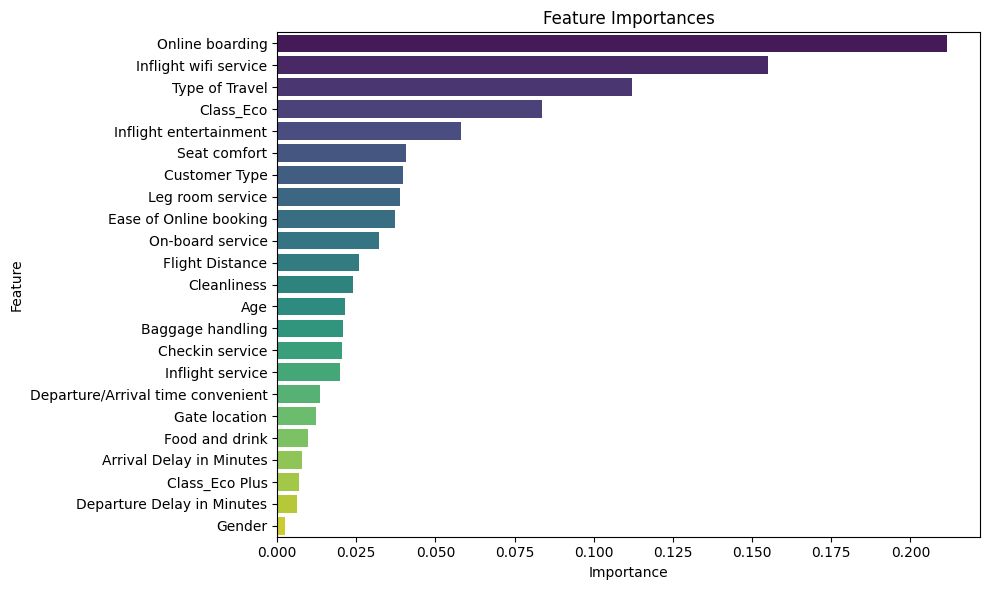

In [7]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv("train (1).csv")
test_df = pd.read_csv("test (1).csv")

train_df.drop(columns=['Unnamed: 0', 'id'], inplace=True, errors='ignore')
test_df.drop(columns=['Unnamed: 0', 'id'], inplace=True, errors='ignore')

train_df['Arrival Delay in Minutes'].fillna(train_df['Arrival Delay in Minutes'].median(), inplace=True)
test_df['Arrival Delay in Minutes'].fillna(test_df['Arrival Delay in Minutes'].median(), inplace=True)

train_df.drop_duplicates(inplace=True)

label_cols = ['Gender', 'Customer Type', 'Type of Travel']
for col in label_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

train_df = pd.get_dummies(train_df, columns=['Class'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Class'], drop_first=True)

train_df['satisfaction'] = train_df['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})
test_df['satisfaction'] = test_df['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})

X_train = train_df.drop(columns=['satisfaction'])
y_train = train_df['satisfaction']
X_test = test_df.drop(columns=['satisfaction'])
y_test = test_df['satisfaction']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(" Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# --- Visualizations Below ---

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Satisfied', 'Satisfied'], yticklabels=['Not Satisfied', 'Satisfied'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
y_probs = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Feature Importance
importances = rf.feature_importances_
features = train_df.drop(columns=['satisfaction']).columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(features)[indices], palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
